In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
random_state = 42
tf.random.set_seed(random_state)
n_features = 5

In [3]:
rfe_sel = ['P_VSA_MR_5', 'Mor04m', 'LUMO / eV', 'E1p', 'HOMO / eV', 'Mor22s', 'P_VSA_LogP_2']

In [4]:
data = pd.read_csv('..\\Data\\ze41_mol_desc_db_red.csv', header=0, sep=';', decimal=',')

In [5]:
col_names = data.columns
X = data[rfe_sel[:n_features]].astype('float32')
y = data[col_names[1]].astype('float32')

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=random_state)
[X_train, X_valid, y_train, y_valid] = [pd.DataFrame(x) for x in [X_train, X_valid, y_train, y_valid]]

In [7]:
scalex = MinMaxScaler(feature_range=(-1,1))
scalex.fit(X_train)
[X_train_sc, X_valid_sc] = [pd.DataFrame(scalex.transform(x), columns=X.columns) for x in [X_train, X_valid]]

In [8]:
scaley = MinMaxScaler(feature_range=(0, 1))
scaley.fit(y_train)
[y_train_sc, y_valid_sc] = [pd.DataFrame(scaley.transform(y), columns=y.columns) for y in [y_train, y_valid]]

In [9]:
class Autoencoder(keras.models.Model):
    def __init__(self, latent_dim=2):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
            #keras.layers.Dense(150, activation='linear'),
            #keras.layers.LeakyReLU(),
            keras.layers.Dense(latent_dim, activation='linear'),
            keras.layers.LeakyReLU(),
        ])
        self.decoder = tf.keras.Sequential([
            #keras.layers.Dense(150, activation='linear'),
            #keras.layers.LeakyReLU(),
            keras.layers.Dense(len(X_train.columns), activation='linear')
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [10]:
autoencoder = Autoencoder(latent_dim=2)

In [11]:
autoencoder.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss='mean_squared_error')

In [12]:
history = autoencoder.fit(X_train_sc, X_train_sc, validation_data=(X_valid_sc, X_valid_sc), epochs=100)

Epoch 1/100
2/2 [==============================] - 0s 47ms/step - loss: 0.3892 - val_loss: 0.5125
Epoch 2/100
2/2 [==============================] - 0s 8ms/step - loss: 0.3652 - val_loss: 0.4677
Epoch 3/100
2/2 [==============================] - 0s 8ms/step - loss: 0.3445 - val_loss: 0.4273
Epoch 4/100
2/2 [==============================] - 0s 8ms/step - loss: 0.3258 - val_loss: 0.3956
Epoch 5/100
2/2 [==============================] - 0s 8ms/step - loss: 0.3063 - val_loss: 0.3689
Epoch 6/100
2/2 [==============================] - 0s 8ms/step - loss: 0.2895 - val_loss: 0.3476
Epoch 7/100
2/2 [==============================] - 0s 8ms/step - loss: 0.2744 - val_loss: 0.3289
Epoch 8/100
2/2 [==============================] - 0s 8ms/step - loss: 0.2606 - val_loss: 0.3116
Epoch 9/100
2/2 [==============================] - 0s 8ms/step - loss: 0.2479 - val_loss: 0.2959
Epoch 10/100
2/2 [==============================] - 0s 8ms/step - loss: 0.2360 - val_loss: 0.2818
Epoch 11/100
2/2 [==========

2/2 [==============================] - 0s 16ms/step - loss: 0.0825 - val_loss: 0.0858
Epoch 85/100
2/2 [==============================] - 0s 8ms/step - loss: 0.0825 - val_loss: 0.0856
Epoch 86/100
2/2 [==============================] - 0s 8ms/step - loss: 0.0823 - val_loss: 0.0853
Epoch 87/100
2/2 [==============================] - 0s 8ms/step - loss: 0.0823 - val_loss: 0.0849
Epoch 88/100
2/2 [==============================] - 0s 8ms/step - loss: 0.0822 - val_loss: 0.0843
Epoch 89/100
2/2 [==============================] - 0s 8ms/step - loss: 0.0822 - val_loss: 0.0841
Epoch 90/100
2/2 [==============================] - 0s 8ms/step - loss: 0.0820 - val_loss: 0.0838
Epoch 91/100
2/2 [==============================] - ETA: 0s - loss: 0.079 - 0s 8ms/step - loss: 0.0820 - val_loss: 0.0837
Epoch 92/100
2/2 [==============================] - 0s 8ms/step - loss: 0.0819 - val_loss: 0.0836
Epoch 93/100
2/2 [==============================] - 0s 8ms/step - loss: 0.0819 - val_loss: 0.0834
Epoch 94

In [13]:
encoded = autoencoder.encoder(X_valid_sc.to_numpy()).numpy()

In [14]:
np.min(encoded, axis=0), np.mean(encoded, axis=0), np.max(encoded, axis=0)

(array([-0.70249975, -0.45507935], dtype=float32),
 array([-0.34396735, -0.27586606], dtype=float32),
 array([ 0.01926969, -0.03812867], dtype=float32))

In [15]:
np.where(np.all(np.isclose(encoded, 0), axis=0))[0]

array([], dtype=int64)

In [16]:
encoded

array([[ 0.01926969, -0.03812867],
       [-0.45151696, -0.23364739],
       [-0.15439384, -0.41310012],
       [-0.4000655 , -0.2768794 ],
       [-0.70249975, -0.45507935],
       [-0.37459782, -0.23836142]], dtype=float32)

In [17]:
encoded.shape

(6, 2)

In [18]:
enc_train = autoencoder.encoder(X_train_sc.to_numpy()).numpy()

In [19]:
enc_train.shape

(54, 2)

In [20]:
X_v_enc = pd.DataFrame(encoded, columns=['enc_dim_1', 'enc_dim_2'], index=X_valid.index)

In [21]:
X_t_enc = pd.DataFrame(enc_train, columns=['enc_dim_1', 'enc_dim_2'], index=X_train.index)

In [22]:
X_enc = X_t_enc.append(X_v_enc)

In [23]:
data[X_enc.columns] = X_enc.sort_index()

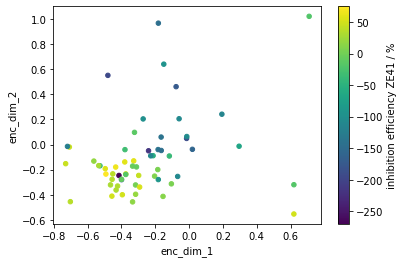

In [24]:
fig, ax = plt.subplots()
data.plot.scatter(x='enc_dim_1', y='enc_dim_2', c = 'inhibition efficiency ZE41 / %', ax=ax, colormap='viridis')
plt.show()

In [25]:
data.head()

,compound,inhibition efficiency ZE41 / %,LinIE ZE41,MW,AMW,Mv,Mi,nTA,RBF,nDB,...,CATS3D_04_LL,CATS3D_05_LL,HOMO / eV,LUMO / eV,Hlgap / eV,Cv / kJ/(mol-K)@293.15K,Cp / kJ/(mol-K)@293.15K,chem_pot / kJ/mol@293.15K,enc_dim_1,enc_dim_2
0,3-Amino-124-triazole,-157,0.328,84.10,8.410,0.609,1.199,1.0,0.000,0.0,...,0.0,0.0,-5.422,0.078,5.500,0.074309,0.082623,127.67,0.019270,-0.038129
1,3-methylcatechol,-31,0.693,124.15,7.303,0.620,1.122,3.0,0.000,0.0,...,1.0,0.0,-5.311,-0.184,5.127,0.135196,0.143511,269.94,-0.379459,-0.040593
2,3-methylsalicylicacid,75,1.000,152.16,8.008,0.645,1.120,4.0,0.053,1.0,...,1.0,0.0,-5.870,-1.812,4.058,0.151551,0.159865,296.04,-0.492186,-0.235177
3,4-aminosalicylicacid,57,0.948,153.15,8.508,0.653,1.132,4.0,0.056,1.0,...,0.0,0.0,-5.545,-1.331,4.215,0.152926,0.161240,267.85,-0.496106,-0.192135
4,4-hydroxybenzoicacid,-170,0.290,138.13,8.633,0.670,1.117,3.0,0.063,1.0,...,0.0,0.0,-6.198,-1.472,4.726,0.132298,0.140612,225.54,-0.399724,-0.279897


In [26]:
model = keras.models.Sequential([
    keras.layers.Dense(50, activation='relu', input_shape=(n_features,)),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1)
])

In [27]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss='mean_squared_error')

In [28]:
dec_train = autoencoder.decoder(enc_train)
dec_valid = autoencoder.decoder(encoded)

In [29]:
#[dec_train, dec_valid] = [pd.DataFrame(x, columns = X.columns) for x in [dec_train, dec_valid]]
#[dec_train, dec_valid] = [np.asarray(x).astype('float32') for x in [dec_train, dec_valid]]

In [30]:
history = model.fit(dec_train, y_train_sc, validation_data=(dec_valid, y_valid_sc), epochs=25)

Epoch 1/25
2/2 [==============================] - 0s 39ms/step - loss: 0.5320 - val_loss: 0.3519
Epoch 2/25
2/2 [==============================] - 0s 8ms/step - loss: 0.2831 - val_loss: 0.0924
Epoch 3/25
2/2 [==============================] - 0s 8ms/step - loss: 0.0951 - val_loss: 0.0196
Epoch 4/25
2/2 [==============================] - 0s 8ms/step - loss: 0.0631 - val_loss: 0.1453
Epoch 5/25
2/2 [==============================] - 0s 8ms/step - loss: 0.1263 - val_loss: 0.0953
Epoch 6/25
2/2 [==============================] - 0s 8ms/step - loss: 0.0764 - val_loss: 0.0150
Epoch 7/25
2/2 [==============================] - 0s 8ms/step - loss: 0.0364 - val_loss: 0.0148
Epoch 8/25
2/2 [==============================] - 0s 8ms/step - loss: 0.0510 - val_loss: 0.0370
Epoch 9/25
2/2 [==============================] - 0s 8ms/step - loss: 0.0661 - val_loss: 0.0385
Epoch 10/25
2/2 [==============================] - 0s 8ms/step - loss: 0.0625 - val_loss: 0.0229
Epoch 11/25
2/2 [=====================

In [56]:
grid_coords = np.linspace(-1, 1, 101)
xv, yv = np.meshgrid(grid_coords, grid_coords)

In [57]:
positions = np.transpose(np.vstack([xv.ravel(), yv.ravel()]))

In [69]:
grid_dec = autoencoder.decoder(positions)
grid_pred = model.predict(grid_dec)
grid_pred = scaley.inverse_transform(grid_pred)

AttributeError: 'PathCollection' object has no property 'ms'

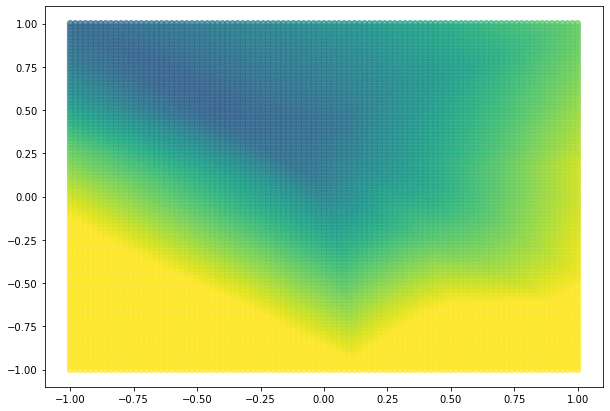

In [84]:
fig, ax = plt.subplots(figsize=(10,7))
p1 = ax.scatter(xv.ravel(), yv.ravel(), c=grid_pred, alpha=0.7, vmin=-270, vmax=75)
data.plot.scatter(x='enc_dim_1', y='enc_dim_2', c = 'inhibition efficiency ZE41 / %', ax=ax,
                  colormap='viridis', edgecolors='black', ms=7)
ax.set_title('Predicted vs. True target value')
ax.set_xlabel('Encoding dimension 1')
ax.set_ylabel('Encoding dimension 2')
plt.show()

In [48]:
positions.shape

(10201, 2)

In [79]:
scalex.get_params(deep=False)

{'copy': True, 'feature_range': (-1, 1)}